In [100]:
#phase 1:
import pandas as pd
import json
import numpy as np
from datetime import datetime, timezone, timedelta
#add the data file:
file_path = 'transit_data.json' 

with open(file_path, 'r') as f:
    raw_data = json.load(f)
#print the records
print(f"Total root records: {len(raw_data)}")
print("Sample of first record structure:", raw_data[0].keys())
#in this we are converting the josn format time stamp into pythonStamp 
def parse_timestamp(ts_input):
    if not ts_input:
        return None
    try:
        
        if isinstance(ts_input, dict) and "$numberLong" in ts_input:
            ts_ms = int(ts_input["$numberLong"])
            return datetime.fromtimestamp(ts_ms / 1000.0, tz=timezone.utc)
        # Handle string format ISO 8601
        if isinstance(ts_input, str):
            return pd.to_datetime(ts_input, utc=True)
    except Exception:
        return None
    return None

print("\n  Part 1 Complete: Data Loaded and Timestamp Parser ready.")

Total root records: 99
Sample of first record structure: dict_keys(['highestSeverity', 'notifications', 'duplicateWaybill', 'moreData', 'trackDetailsCount', 'trackDetails'])

  Part 1 Complete: Data Loaded and Timestamp Parser ready.


In [101]:
#phase 2:
flattened_data = []

for entry in raw_data:
    # Edge Case: Shipment data is inside 'trackDetails' list
    track_details_list = entry.get("trackDetails", [])
    
    for record in track_details_list:
     
        
        # 1. Identifiers
        tracking_num = record.get("trackingNumber")
        service_type = record.get("service", {}).get("type", "Unknown")
        carrier_code = record.get("carrierCode")
        
        # 2. Weight (Handle missing units/values safely)
        weight_obj = record.get("packageWeight", {})
        weight_val = weight_obj.get("value") if weight_obj.get("units") in ['KG', 'kg', 'Kg'] else None
        packaging = record.get("packaging", {}).get("type")

        # 3. Location Info (Safely extract using .get to avoid crashes)
        shipper = record.get("shipperAddress", {})
        dest = record.get("destinationAddress", {})
        
        row = {
            "tracking_number": tracking_num,
            "service_type": service_type,
            "carrier_code": carrier_code,
            "package_weight_kg": weight_val,
            "packaging_type": packaging,
            "origin_city": shipper.get("city"),
            "origin_state": shipper.get("stateOrProvinceCode"),
            "origin_pincode": shipper.get("postalCode"),
            "destination_city": dest.get("city"),
            "destination_state": dest.get("stateOrProvinceCode"),
            "destination_pincode": dest.get("postalCode"),
            # We store the raw events list here to process in Part 3
            "raw_events": record.get("events", []) 
        }
        
        flattened_data.append(row)

print(f" Part 2 Complete: Extracted {len(flattened_data)} shipments.")

 Part 2 Complete: Extracted 99 shipments.


In [130]:
# Parse event timestamps into datetime and sort them Structred Way
parsed_events = []
for e in events:
    ts = parse_timestamp(e.get("timestamp"))
    if ts:
        temp = e.copy()
        temp['parsed_time'] = ts
        parsed_events.append(temp)

parsed_events.sort(key=lambda x: x['parsed_time'])

# Variables used to compute different movement metrics
pickup_time = None
delivery_time = None
unique_facilities = set()
in_transit_count = 0
od_attempts = 0
delivery_loc_type = None

if not parsed_events:
    # If the item has no events at all, fill with defaults
    row.update({
        "total_transit_hours": 0.0,
        "num_facilities_visited": 0,
        "num_in_transit_events": 0,
        "first_attempt_delivery": False,
        "avg_hours_per_facility": 0.0
    })
else:
    for event in parsed_events:
        e_type = event.get("eventType")
        loc_type = event.get("arrivalLocation", "")

        # Track which facilities the shipment has passed through
        if isinstance(loc_type, str) and "FACILITY" in loc_type.upper():
            unique_facilities.add(loc_type)

        # Count movement-related events
        if e_type in ["IT", "AR", "DP", "AF"]:
            in_transit_count += 1

        # Out-for-delivery attempts
        if e_type == "OD":
            od_attempts += 1

        # Pickup and delivery timestamps
        if e_type == "PU" and pickup_time is None:
            pickup_time = event['parsed_time']

        if e_type == "DL":
            delivery_time = event['parsed_time']
            delivery_loc_type = event.get("deliveryLocationType")

    # If no actual pickup scan exists, assume the first event as the start
    if pickup_time is None:
        pickup_time = parsed_events[0]['parsed_time']

    # Total transit time (pickup → delivery)
    total_hours = 0.0
    if pickup_time and delivery_time:
        total_hours = (delivery_time - pickup_time).total_seconds() / 3600

    # Time spent between first and last facility scans
    facility_times = [
        e['parsed_time']
        for e in parsed_events
        if "FACILITY" in str(e.get("arrivalLocation", "")).upper()
    ]

    inter_facility_hours = 0.0
    if len(facility_times) > 1:
        inter_facility_hours = (
            facility_times[-1] - facility_times[0]
        ).total_seconds() / 3600

    # Write all the computed fields back to the row
    row['pickup_datetime_ist'] = pickup_time.astimezone(IST_OFFSET) if pickup_time else None
    row['delivery_datetime_ist'] = delivery_time.astimezone(IST_OFFSET) if delivery_time else None
    row['total_transit_hours'] = round(max(total_hours, 0), 2)
    row['num_facilities_visited'] = len(unique_facilities)
    row['num_in_transit_events'] = in_transit_count
    row['time_in_inter_facility_transit_hours'] = round(inter_facility_hours, 2)

    # Avoid divide-by-zero
    if row['num_facilities_visited'] > 0:
        row['avg_hours_per_facility'] = round(
            row['total_transit_hours'] / row['num_facilities_visited'], 2
        )
    else:
        row['avg_hours_per_facility'] = 0.0

    row['num_out_for_delivery_attempts'] = od_attempts
    row['first_attempt_delivery'] = (od_attempts == 1)
    row['delivery_location_type'] = delivery_loc_type
    row['is_express_service'] = "EXPRESS" in str(row.get('service_type', '')).upper()
    row['total_events_count'] = len(parsed_events)
df_detailed = pd.DataFrame(flattened_data)
print(df_detailed)
#what does this explain when the order delivered and how many times it went for out for delivery 

   tracking_number         service_type carrier_code  package_weight_kg  \
0     391128701026  FEDEX_EXPRESS_SAVER         FDXE               14.0   
1     390901883808  FEDEX_EXPRESS_SAVER         FDXE               14.0   
2     391128749178  FEDEX_EXPRESS_SAVER         FDXE               14.0   
3     390807986805  FEDEX_EXPRESS_SAVER         FDXE               14.0   
4     390948921190  FEDEX_EXPRESS_SAVER         FDXE               14.0   
..             ...                  ...          ...                ...   
94    280439181099  FEDEX_EXPRESS_SAVER         FDXE               32.0   
95    281222569500  FEDEX_EXPRESS_SAVER         FDXE               22.5   
96    280307632740  FEDEX_EXPRESS_SAVER         FDXE                2.0   
97    280307633276  FEDEX_EXPRESS_SAVER         FDXE                2.0   
98    280993568461  FEDEX_EXPRESS_SAVER         FDXE                1.5   

    packaging_type origin_city origin_state origin_pincode destination_city  \
0   YOUR_PACKAGING  

In [132]:
#Makes the shipment processing logic robust even when the data is messy. 

def get_event_key(event):
    # Create a unique key based on time and type to find duplicates
    return (str(event.get('timestamp')), event.get('eventType'))

for row in flattened_data:
    #edge case:
    #If raw_events is missing → use empty list instead of crashing.
    events = row.pop('raw_events', []) 
    
    parsed_events = []
    seen_events = set()
    
    for e in events:
       #edge case:
        #Remove duplicate events
        event_key = get_event_key(e)
        if event_key in seen_events:
            continue # Skip this duplicate
        seen_events.add(event_key)

        #If timestamp is bad → skip event.
        ts = parse_timestamp(e.get("timestamp"))
        
        if ts:
            e_copy = e.copy()
            e_copy['parsed_time'] = ts
            parsed_events.append(e_copy)
    
    #Even if events came in wrong order, timing calculations remain correct.
    parsed_events.sort(key=lambda x: x['parsed_time'])
    
    # --- METRICS CALCULATION ---
    pickup_time = None
    delivery_time = None
    unique_facilities = set()
    in_transit_count = 0
    od_attempts = 0
    delivery_loc_type = None

    # Edge: "Events array being empty" (Logic Check)
    if not parsed_events:
        row.update({
            "total_transit_hours": 0.0,
            "num_facilities_visited": 0,
            "num_in_transit_events": 0,
            "first_attempt_delivery": False,
            "avg_hours_per_facility": 0.0,
            "num_out_for_delivery_attempts": 0,
            "status": "No Events Found"
        })
    else:
        for event in parsed_events:
            #"Missing or null values in any field"
            # We use .get() everywhere to avoid "KeyError" crashes
            e_type = event.get("eventType")
            loc_type = event.get("arrivalLocation", "")
            
            # 1. Facility Touchpoints
            if isinstance(loc_type, str) and "FACILITY" in loc_type.upper():
                unique_facilities.add(loc_type)
            
            # 2. In Transit Counts
            if e_type in ["IT", "AR", "DP", "AF"]:
                in_transit_count += 1
            
            # 3. Out for Delivery Logic
            if e_type == "OD":
                od_attempts += 1

            # 4. Timestamp Logic
            if e_type == "PU" and pickup_time is None:
                pickup_time = event['parsed_time']
            if e_type == "DL":
                delivery_time = event['parsed_time']
                # EDGE CASE: "Nested fields that may not exist"
                # Sometimes deliveryLocationType is in the event, sometimes in the root
                if "deliveryLocationType" in event:
                    delivery_loc_type = event.get("deliveryLocationType")
        
        # EDGE CASE: "Incomplete event sequences" (Missing PU Scan)
        # If no explicit 'PU' event exists, we default to the first event time
        if pickup_time is None and len(parsed_events) > 0:
            pickup_time = parsed_events[0]['parsed_time']
            
        # Transit Time Analysis
        total_hours = 0.0
        if pickup_time and delivery_time:
            total_hours = (delivery_time - pickup_time).total_seconds() / 3600.0
        
        # Inter-Facility Transit Time
        facility_times = [e['parsed_time'] for e in parsed_events 
                          if "FACILITY" in str(e.get("arrivalLocation", "")).upper()]
        
        inter_facility_hours = 0.0
        if len(facility_times) > 1:
            inter_facility_hours = (facility_times[-1] - facility_times[0]).total_seconds() / 3600.0

       
        row['pickup_datetime_ist'] = pickup_time.astimezone(IST_OFFSET) if pickup_time else None
        row['delivery_datetime_ist'] = delivery_time.astimezone(IST_OFFSET) if delivery_time else None
        row['total_transit_hours'] = round(max(total_hours, 0), 2)
        row['num_facilities_visited'] = len(unique_facilities)
        row['num_in_transit_events'] = in_transit_count
        row['time_in_inter_facility_transit_hours'] = round(inter_facility_hours, 2)
        
        # velocity
        if row['num_facilities_visited'] > 0:
            row['avg_hours_per_facility'] = round(row['total_transit_hours'] / row['num_facilities_visited'], 2)
        else:
            row['avg_hours_per_facility'] = 0.0
            
        row['num_out_for_delivery_attempts'] = od_attempts
        row['first_attempt_delivery'] = (od_attempts == 1)
        row['delivery_location_type'] = delivery_loc_type
        
        # edge: missing Service Type
        # handle if service_type is none/null
        svc = str(row['service_type']) if row['service_type'] else ""
        row['is_express_service'] = True if "EXPRESS" in svc.upper() else False
        row['total_events_count'] = len(parsed_events)

# Re-create DataFrame with the robust data
df_detailed = pd.DataFrame(flattened_data)

print(" Part 4 verified: edge cases handled within the logic loop.")

 Part 4 verified: edge cases handled within the logic loop.


In [155]:

df_detailed = pd.DataFrame(processed_rows)

if not df_detailed.empty:
    # 1. Save Detailed CSV
    # Define exact column order as per assignment
    cols_ordered = [
        "tracking_number", "service_type", "carrier_code", "package_weight_kg", 
        "packaging_type", "origin_city", "origin_state", "origin_pincode", 
        "destination_city", "destination_state", "destination_pincode", 
        "pickup_datetime_ist", "delivery_datetime_ist", "total_transit_hours", 
        "num_facilities_visited", "num_in_transit_events", 
        "time_in_inter_facility_transit_hours", "avg_hours_per_facility", 
        "is_express_service", "delivery_location_type", 
        "num_out_for_delivery_attempts", "first_attempt_delivery", "total_events_count"
    ]
    df_final = df_detailed.reindex(columns=cols_ordered)
    df_final.to_csv("transit_performance_detailed.csv", index=False)
    print(" Success: 'transit_performance_detailed.csv' created.")

    # 2. Calculate Summary Metrics
    transit_series = df_detailed['total_transit_hours']
    facilities_series = df_detailed['num_facilities_visited']
    
    df_overall = pd.DataFrame([{
        'total_shipments_analyzed': len(df_detailed),
        'avg_transit_hours': round(transit_series.mean(), 2),
        'median_transit_hours': round(transit_series.median(), 2),
        'std_dev_transit_hours': round(transit_series.std(), 2),
        'min_transit_hours': round(transit_series.min(), 2),
        'max_transit_hours': round(transit_series.max(), 2),
        'avg_facilities_per_shipment': round(facilities_series.mean(), 2),
        'median_facilities_per_shipment': round(facilities_series.median(), 2),
        'mode_facilities_per_shipment': facilities_series.mode()[0] if not facilities_series.mode().empty else 0,
        'avg_hours_per_facility': round(df_detailed['avg_hours_per_facility'].mean(), 2),
        'median_hours_per_facility': round(df_detailed['avg_hours_per_facility'].median(), 2),
        'pct_first_attempt_delivery': round((df_detailed['first_attempt_delivery'].mean() * 100), 2),
        'avg_out_for_delivery_attempts': round(df_detailed['num_out_for_delivery_attempts'].mean(), 2)
    }])

    # 3. Calculate Service Type Breakdown
    df_service = df_detailed.groupby('service_type').agg(
        avg_transit_hours_by_service_type=('total_transit_hours', 'mean'),
        avg_facilities_by_service_type=('num_facilities_visited', 'mean'),
        count_shipments_by_service_type=('tracking_number', 'count')
    ).reset_index().round(2)

    # 4. Save Summary CSV (Report Style)
    with open("transit_performance_summary.csv", 'w') as f:
        f.write("--- OVERALL NETWORK METRICS ---\n")
        df_overall.to_csv(f, index=False)
        f.write("\n--- SERVICE TYPE COMPARISON ---\n")
        df_service.to_csv(f, index=False)
        
    print("✅ Success: 'transit_performance_summary.csv' created.")
    
    # Preview
    print("\n--- Summary Data Preview ---")
    print(df_overall.T)
else:
    print("Error: No data processed")

 Success: 'transit_performance_detailed.csv' created.
✅ Success: 'transit_performance_summary.csv' created.

--- Summary Data Preview ---
                                     0
total_shipments_analyzed         99.00
avg_transit_hours                94.01
median_transit_hours             93.25
std_dev_transit_hours            64.83
min_transit_hours                15.33
max_transit_hours               544.28
avg_facilities_per_shipment       2.83
median_facilities_per_shipment    3.00
mode_facilities_per_shipment      3.00
avg_hours_per_facility           34.04
median_hours_per_facility        31.62
pct_first_attempt_delivery       63.64
avg_out_for_delivery_attempts     0.97


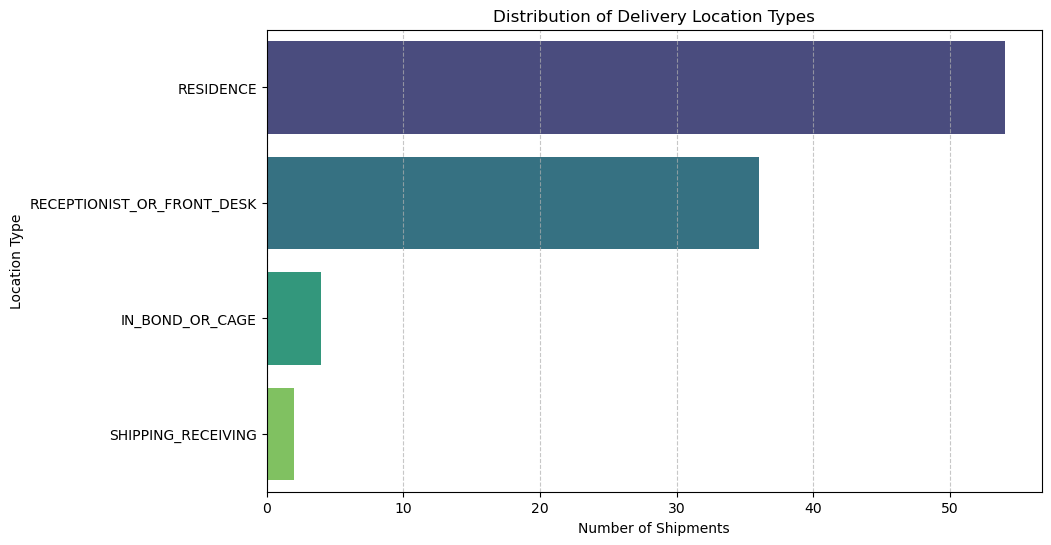

In [179]:
#why we need to see in bar chat is like the delv location has only 3-4 place so i need find which has least order location
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(
    y='delivery_location_type', 
    data=df_detailed, 
    order=df_detailed['delivery_location_type'].value_counts().index,
    palette='viridis',
    hue='delivery_location_type',  
    legend=False                   
)

plt.title('Distribution of Delivery Location Types')
plt.xlabel('Number of Shipments')
plt.ylabel('Location Type')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

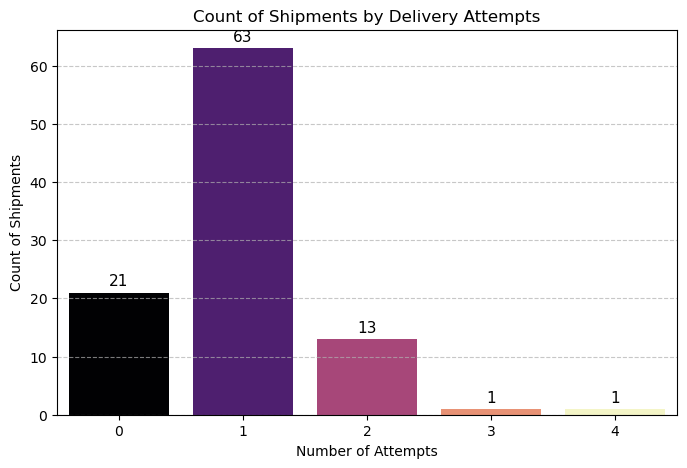

In [175]:
#i wanted to check number of attempt the order del in First time
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 5))

# Fixed Code
ax = sns.countplot(
    x='num_out_for_delivery_attempts', 
    data=df_detailed, 
    palette='magma',
    hue='num_out_for_delivery_attempts', 
    legend=False                         
)


for p in ax.patches:
    if p.get_height() > 0: 
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')

plt.title('Count of Shipments by Delivery Attempts')
plt.xlabel('Number of Attempts')
plt.ylabel('Count of Shipments')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

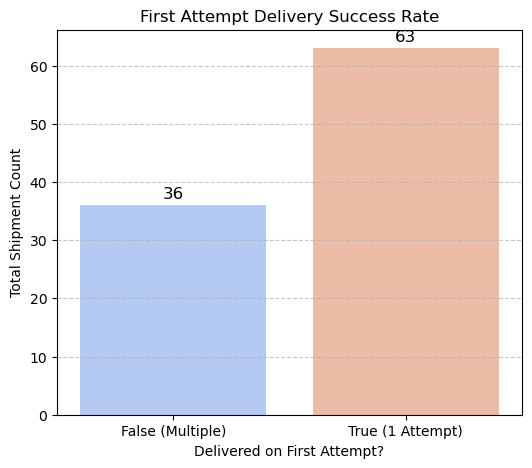

In [177]:
#success ratio del in first attempt
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 5))

ax = sns.countplot(
    x='first_attempt_delivery', 
    data=df_detailed, 
    palette='coolwarm',
    hue='first_attempt_delivery', # <--- The Fix
    legend=False                  # <--- The Fix
)


for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                    textcoords='offset points')

plt.title('First Attempt Delivery Success Rate')
plt.xlabel('Delivered on First Attempt?')
plt.ylabel('Total Shipment Count')
plt.xticks([0, 1], ['False (Multiple)', 'True (1 Attempt)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

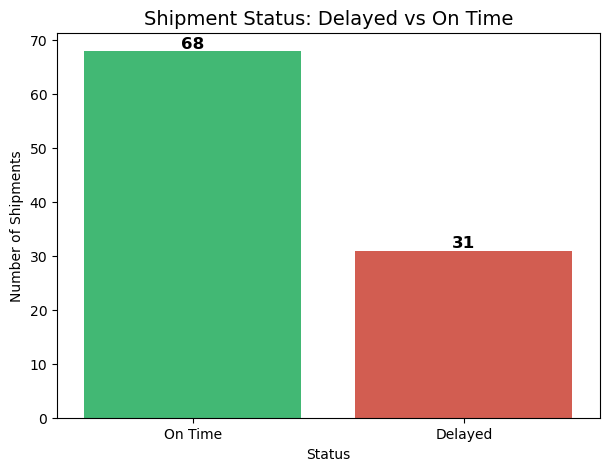

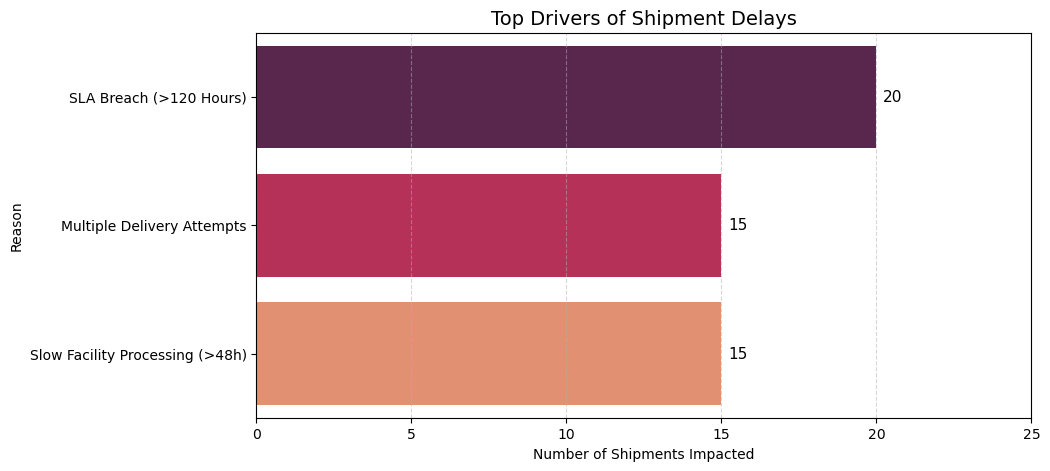


 Delay -Report
status_label
On Time    68.69%
Delayed    31.31%
Name: proportion, dtype: object


In [185]:

#how i classified is A shipment is classified as Delayed if any of the following happened:
️# Delivery took more than 120 hours
# Driver attempted delivery more than once
# Shipment spent too much waiting inside facilities (>48 hours per facility)
import matplotlib.pyplot as plt
import seaborn as sns


df_detailed["is_delayed"] = (
    (df_detailed["total_transit_hours"] > 120) |
    (df_detailed["num_out_for_delivery_attempts"] > 1) |
    (df_detailed["avg_hours_per_facility"] > 48)
)

df_detailed["status_label"] = df_detailed["is_delayed"].map({True: "Delayed", False: "On Time"})


plt.figure(figsize=(7, 5))
ax1 = sns.countplot(
    x="status_label", 
    data=df_detailed, 
    palette={"Delayed": "#e74c3c", "On Time": "#2ecc71"},
    hue="status_label",
    legend=False
)

# Add labels
for p in ax1.patches:
    if p.get_height() > 0:
        ax1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title("Shipment Status: Delayed vs On Time", fontsize=14)
plt.ylabel("Number of Shipments")
plt.xlabel("Status")
plt.show()


delay_reasons = {
    "SLA Breach (>120 Hours)": len(df_detailed[df_detailed["total_transit_hours"] > 120]),
    "Multiple Delivery Attempts": len(df_detailed[df_detailed["num_out_for_delivery_attempts"] > 1]),
    "Slow Facility Processing (>48h)": len(df_detailed[df_detailed["avg_hours_per_facility"] > 48])
}

df_reasons = pd.DataFrame(list(delay_reasons.items()), columns=["Reason", "Count"])
df_reasons = df_reasons.sort_values("Count", ascending=False)

plt.figure(figsize=(10, 5))
ax2 = sns.barplot(
    x="Count", 
    y="Reason", 
    data=df_reasons, 
    palette="rocket",
    hue="Reason",
    legend=False
)

# Add labels
for p in ax2.patches:
    ax2.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2),
                 ha='left', va='center', xytext=(5, 0), textcoords='offset points', fontsize=11)

plt.title("Top Drivers of Shipment Delays", fontsize=14)
plt.xlabel("Number of Shipments Impacted")
plt.xlim(0, max(df_reasons["Count"]) + 5)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

print("\n Delay -Report")
print(df_detailed["status_label"].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')

In [187]:
# ==========================================
# PART 6: STRUCTURED UNIFIED SUMMARY CSV
# ==========================================

if df_detailed.empty:
    print("❌ Error: No data to summarize.")
else:
    # 1. Define the Metric Logic (The "Recipe" for the summary)
    # We define how to calculate every column requested in the assignment
    agg_recipe = {
        'total_transit_hours': ['mean', 'median', 'std', 'min', 'max'],
        'num_facilities_visited': ['mean', 'median', lambda x: x.mode()[0] if not x.mode().empty else 0],
        'avg_hours_per_facility': ['mean', 'median'],
        'first_attempt_delivery': [lambda x: (x.sum() / len(x)) * 100], # Custom function for %
        'num_out_for_delivery_attempts': ['mean'],
        'tracking_number': ['count']
    }

    # 2. Calculate Service Level Metrics (Grouped)
    df_service_summary = df_detailed.groupby('service_type').agg(agg_recipe)
    df_service_summary.reset_index(inplace=True)
    
    # 3. Calculate Overall Network Metrics (Global)
    # We map the whole dataframe to the same recipe
    # Create a temporary 'service_type' column for the overall row
    df_overall_temp = df_detailed.copy()
    df_overall_temp['service_type'] = 'OVERALL_NETWORK'
    df_overall_summary = df_overall_temp.groupby('service_type').agg(agg_recipe)
    df_overall_summary.reset_index(inplace=True)

    # 4. Combine and Flatten Columns
    # Pandas creates nested columns like (total_transit_hours, mean). We need to flatten them.
    df_final_summary = pd.concat([df_overall_summary, df_service_summary], ignore_index=True)
    
    # Rename columns to match assignment requirements strictly
    new_columns = [
        'service_type',
        'avg_transit_hours', 'median_transit_hours', 'std_dev_transit_hours', 'min_transit_hours', 'max_transit_hours',
        'avg_facilities_per_shipment', 'median_facilities_per_shipment', 'mode_facilities_per_shipment',
        'avg_hours_per_facility', 'median_hours_per_facility',
        'pct_first_attempt_delivery',
        'avg_out_for_delivery_attempts',
        'total_shipments_analyzed'
    ]
    
    # Assign the new flat column names
    df_final_summary.columns = new_columns

    # 5. Rounding for professional look
    df_final_summary = df_final_summary.round(2)

    # 6. Save to CSV
    df_final_summary.to_csv("transit_performance_summary.csv", index=False)
    
    print("✅ Success: A clean, structured 'transit_performance_summary.csv' has been generated.")
    print("   - Row 1: Overall Network Stats")
    print("   - Row 2+: Service Type Breakdown")
    
    # Preview
    print("\n--- Summary Data Preview ---")
    print(df_final_summary.T)

✅ Success: A clean, structured 'transit_performance_summary.csv' has been generated.
   - Row 1: Overall Network Stats
   - Row 2+: Service Type Breakdown

--- Summary Data Preview ---
                                              0                    1
service_type                    OVERALL_NETWORK  FEDEX_EXPRESS_SAVER
avg_transit_hours                         94.01                94.01
median_transit_hours                      93.25                93.25
std_dev_transit_hours                     64.83                64.83
min_transit_hours                         15.33                15.33
max_transit_hours                        544.28               544.28
avg_facilities_per_shipment                2.83                 2.83
median_facilities_per_shipment              3.0                  3.0
mode_facilities_per_shipment                  3                    3
avg_hours_per_facility                    34.04                34.04
median_hours_per_facility                 31.62         